<a href="https://colab.research.google.com/github/gu12934/LHL_Final_Capstone_Project/blob/main/SQL_Credit_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import pandas as pd
import sqlite3

Get df

In [2]:
#https://stackoverflow.com/questions/13411544/delete-a-column-from-a-pandas-dataframe
input_df=pd.read_csv('/content/cleaned_data_india_credit.csv')

Drop Index Column

In [3]:
input_df.drop('index', axis=1)

if 'index' in input_df.columns:
    input_df.drop('index', axis=1, inplace=True)

In [5]:
input_df.head()

,City,Date,Card Type,Exp Type,Gender,Amount,Country,Month,Day
0,Delhi,2014-10-29,Gold,Bills,Female,82475,India,October,Wednesday
1,Greater Mumbai,2014-08-22,Platinum,Bills,Female,32555,India,August,Friday
2,Bengaluru,2014-08-27,Silver,Bills,Female,101738,India,August,Wednesday
3,Greater Mumbai,2014-04-12,Signature,Bills,Female,123424,India,April,Saturday
4,Bengaluru,2015-05-05,Gold,Bills,Female,171574,India,May,Tuesday


Renaming Columns

In [6]:
input_df.rename(columns={'Exp Type': 'Exp_Type'}, inplace=True)

In [7]:
input_df.rename(columns={'Card Type': 'Card_Type'}, inplace=True)

In [8]:
input_df.head()

,City,Date,Card_Type,Exp_Type,Gender,Amount,Country,Month,Day
0,Delhi,2014-10-29,Gold,Bills,Female,82475,India,October,Wednesday
1,Greater Mumbai,2014-08-22,Platinum,Bills,Female,32555,India,August,Friday
2,Bengaluru,2014-08-27,Silver,Bills,Female,101738,India,August,Wednesday
3,Greater Mumbai,2014-04-12,Signature,Bills,Female,123424,India,April,Saturday
4,Bengaluru,2015-05-05,Gold,Bills,Female,171574,India,May,Tuesday


Connect SQL

In [9]:
#this was used -https://www.linkedin.com/pulse/accessing-sqlite3-database-from-jupyter-notebook-using-varun-lobo/

conn=sqlite3.connect('mytable.db')

Get df into SQl

In [10]:
input_df.to_sql(name="india_credit",con=conn,if_exists='replace',index=False)
conn.comit()

AttributeError: 'sqlite3.Connection' object has no attribute 'comit'

Load SQLlite

In [11]:
%load_ext sql
%sql sqlite:///mytable.db

Pre-question: Find out attributes of the table


In [12]:
%%sql

SELECT * FROM india_credit LIMIT 5;

 * sqlite:///mytable.db
Done.


City,Date,Card_Type,Exp_Type,Gender,Amount,Country,Month,Day
Delhi,2014-10-29,Gold,Bills,Female,82475,India,October,Wednesday
Greater Mumbai,2014-08-22,Platinum,Bills,Female,32555,India,August,Friday
Bengaluru,2014-08-27,Silver,Bills,Female,101738,India,August,Wednesday
Greater Mumbai,2014-04-12,Signature,Bills,Female,123424,India,April,Saturday
Bengaluru,2015-05-05,Gold,Bills,Female,171574,India,May,Tuesday


pre-question 2: What are the highest spending amounts for a month in top 5 cities

In [13]:
%%sql

SELECT  City, Amount
FROM india_credit
GROUP BY City
ORDER by Amount DESC
LIMIT 5;

 * sqlite:///mytable.db
Done.


City,Amount
Ahmedabad,668568
Tekkalakote,298938
Nautanwa,298676
Puranpur,298518
Tikamgarh,298476


Question 1:
write a query to print top 5 cities with highest spends and their percentage contribution of total credit card spends

In [28]:
%%sql
SELECT
    City,
    SUM(Amount) AS TotalSpend,
    (SUM(Amount) * 100.0 / (SELECT SUM(Amount) FROM india_credit)) AS PercentageOfTotal
FROM
    india_credit
GROUP BY
    City
ORDER BY
    TotalSpend DESC
LIMIT 5;


 * sqlite:///mytable.db
Done.


City,TotalSpend,PercentageOfTotal
Greater Mumbai,576751476,14.153989211474931
Bengaluru,572326739,14.045402268280677
Ahmedabad,567794310,13.9341724685536
Delhi,556929212,13.667533393886337
Kolkata,115466943,2.8336604820478875


Question 2: write a query to print highest spend month and amount spent in that month for each card type

In [30]:
%%sql
SELECT
    Card_Type,
    Month,
    SUM(Amount) AS TotalSpend
FROM
    india_credit
GROUP BY
    City
ORDER BY
    TotalSpend DESC
LIMIT 5;


 * sqlite:///mytable.db
Done.


Card_Type,Month,TotalSpend
Platinum,August,576751476
Silver,August,572326739
Gold,October,567794310
Gold,October,556929212
Silver,November,115466943


Question 3: write a query to print 3 columns: city, highest_expense_type , lowest_expense_type (example format : Delhi , bills, Fuel)

In [31]:
%%sql
WITH highest_city_expense AS ( -- cte for highest bill per city
        SELECT
          City,
          Exp_Type,
          SUM(Amount) AS Highest_Amount_Spent,
          RANK() OVER (PARTITION BY City ORDER BY SUM(Amount) DESC) as high_rank -- ranking the expenses per city, highest to lowest
        FROM india_credit
        GROUP BY City, Exp_Type
),
lowest_city_expense AS (-- cte for lowest bill per city
        SELECT
          City,
          Exp_Type,
          SUM(Amount) as Lowest_Amount_Spent,
          RANK() OVER (PARTITION BY City ORDER BY SUM(Amount) ASC) as low_rank -- ranking the expenses per city, lowest to highest
        FROM india_credit
        GROUP BY City, Exp_Type
)
SELECT h.City, h.Exp_Type highest_expense_type, l.Exp_Type lowest_expense_type
FROM highest_city_expense h
join lowest_city_expense l
on h.City = l.City
WHERE h.high_rank = 1
and l.low_rank = 1
order by h.Highest_Amount_Spent desc

 * sqlite:///mytable.db
Done.


City,highest_expense_type,lowest_expense_type
Greater Mumbai,Bills,Entertainment
Bengaluru,Bills,Grocery
Ahmedabad,Bills,Grocery
Delhi,Bills,Entertainment
Surat,Entertainment,Travel
Hyderabad,Grocery,Travel
Lucknow,Grocery,Travel
Kanpur,Food,Travel
Kolkata,Entertainment,Travel
Chennai,Grocery,Fuel


Question 4: write a query to find city which had lowest percentage spend for gold card type

In [33]:
%%sql

SELECT City -- returning only the city name

FROM
        (
                SELECT
                      City,
                      ROUND( -- rounding the result of the inner calculation to 4 decimal places
                                    (
                                            SUM(Amount)  -- the total amount each city spent on gold card
                                                              /    -- dividing city amount/total amount
                                            (    -- using this subquery to get the total amount spent using Gold Card type
                                                SELECT SUM(Amount)
                                                 FROM india_credit
                                                 WHERE Card_Type = 'Gold'
                                            )
                                    ) * 100

                              ,4) AS  Percentage_to_Total
                FROM india_credit
                WHERE Card_Type = 'Gold'
                GROUP BY City
                ORDER BY Percentage_to_Total ASC -- ordering from the lowest to the highest percentage
                LIMIT 1 -- this will limit to just 1, which is the lowest percentage
            )

 * sqlite:///mytable.db
Done.


City
Achalpur


Question 5: write a query to find city which had the highest percentage spend for gold card type

In [34]:
%%sql

SELECT City -- returning only the city name

FROM
        (
                SELECT
                      City,
                      ROUND( -- rounding the result of the inner calculation to 4 decimal places
                                    (
                                            SUM(Amount)  -- the total amount each city spent on gold card
                                                              /    -- dividing city amount/total amount
                                            (    -- using this subquery to get the total amount spent using Gold Card type
                                                SELECT SUM(Amount)
                                                 FROM india_credit
                                                 WHERE Card_Type = 'Gold'
                                            )
                                    ) * 100

                              ,4) AS  Percentage_to_Total
                FROM india_credit
                WHERE Card_Type = 'Gold'
                GROUP BY City
                ORDER BY Percentage_to_Total DESC -- ordering from the highest to the lowest percentage
                LIMIT 1 -- this will limit to just 1, which is the highest percentage
            )

 * sqlite:///mytable.db
Done.


City
Zira


Question 6: write a query to print the transaction details(all columns from the table) for each card type when it reaches a cumulative of 1000000 total spends(We should have 4 rows in the o/p one for each card type)

In [36]:
%%sql

/*
this code calculates the cumulative spend for each row in the "NewIndianCCTable" table, filters the rows to include only those with a cumulative spend greater than or equal to 1000000, and then retrieves the first row for each "Card_Type" based on the "Transaction_Date" order.*/
WITH cumulative_spend AS (
    -- this part of the CTE calculates the cumulative total spend
    SELECT
        *,
        SUM(Amount) OVER (PARTITION BY Card_Type ORDER BY Date) AS Cumulative_Spend
    FROM india_credit
)
SELECT *
FROM (
    SELECT
        *,
        -- each card type is cumulative total spend is ranked with row number window function
        ROW_NUMBER() OVER (PARTITION BY Card_Type ORDER BY Date) AS row_num
    FROM cumulative_spend
    WHERE Cumulative_Spend >= 1000000  -- only cumulative spend greater or equal to 100,000 are selected
)
WHERE row_num = 1;

 * sqlite:///mytable.db
Done.


City,Date,Card_Type,Exp_Type,Gender,Amount,Country,Month,Day,Cumulative_Spend,row_num
Greater Mumbai,2013-10-04,Gold,Bills,Female,990700,India,October,Friday,3414108,1
Ahmedabad,2013-10-05,Platinum,Bills,Female,612572,India,October,Saturday,2927937,1
Delhi,2013-10-04,Signature,Bills,Female,735037,India,October,Friday,2848983,1
Delhi,2013-10-04,Silver,Food,Female,122944,India,October,Friday,2550754,1


World cloud importing

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [17]:

df=pd.read_csv('/content/cleaned_data_india_credit.csv')

In [18]:
df.head()

,index,City,Date,Card Type,Exp Type,Gender,Amount,Country,Month,Day
0,0,Delhi,2014-10-29,Gold,Bills,Female,82475,India,October,Wednesday
1,1,Greater Mumbai,2014-08-22,Platinum,Bills,Female,32555,India,August,Friday
2,2,Bengaluru,2014-08-27,Silver,Bills,Female,101738,India,August,Wednesday
3,3,Greater Mumbai,2014-04-12,Signature,Bills,Female,123424,India,April,Saturday
4,4,Bengaluru,2015-05-05,Gold,Bills,Female,171574,India,May,Tuesday


In [19]:
text = " ".join(City for City in df.City)

In [20]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

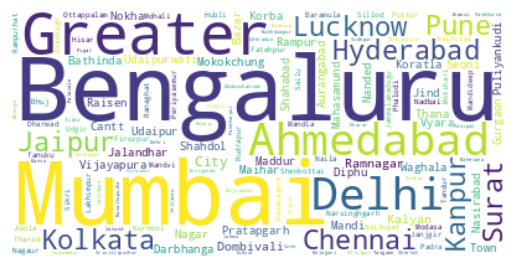

In [21]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
df.rename(columns={'Exp Type': 'Exp_Type'}, inplace=True)

In [23]:
df.head()

,index,City,Date,Card Type,Exp_Type,Gender,Amount,Country,Month,Day
0,0,Delhi,2014-10-29,Gold,Bills,Female,82475,India,October,Wednesday
1,1,Greater Mumbai,2014-08-22,Platinum,Bills,Female,32555,India,August,Friday
2,2,Bengaluru,2014-08-27,Silver,Bills,Female,101738,India,August,Wednesday
3,3,Greater Mumbai,2014-04-12,Signature,Bills,Female,123424,India,April,Saturday
4,4,Bengaluru,2015-05-05,Gold,Bills,Female,171574,India,May,Tuesday


In [24]:
text_1= " ".join(Exp_Type for Exp_Type in df.Exp_Type)

In [25]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text_1)

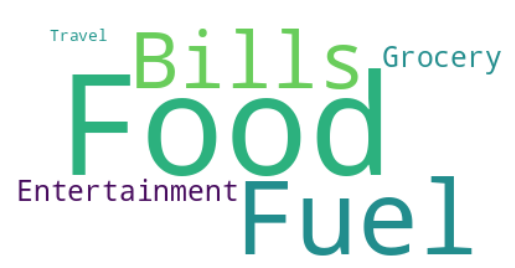

In [26]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()